In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#first look at the columns in each table
inspector=inspect(engine)
measurementcolumns =inspector.get_columns('Measurement')
print('Columns for measurement')
for column in measurementcolumns:
    print(column["name"], column["type"])
print('Columns for station')
stationcolumns =inspector.get_columns('station')
for column in stationcolumns:
    print(column["name"], column["type"])



Columns for measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Columns for station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


2017-08-23
2016-08-22 00:00:00


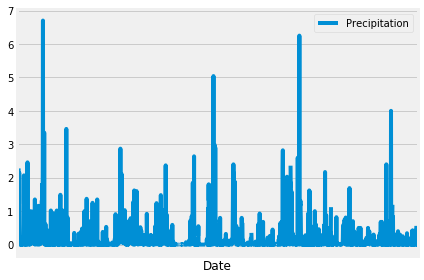

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
laststr=str(last[0])
print(laststr)
#had to import datetime from datetime for strptime
from datetime import datetime
lastdate=datetime.strptime(laststr , '%Y-%m-%d')
#not sure why but I had to change to 366 to ensure it included 8/23/2016
year_ago = lastdate - dt.timedelta(days=366)
print(year_ago)
# Perform a query to retrieve the data and precipitation scores 
#prcpsumbydate =session.query(Measurement.date, func.sum(Measurement.prcp).label('sum_prcp')).filter(Measurement.date>=year_ago).\
#group_by(Measurement.date).order_by(Measurement.date).all()
prcpbydate = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).filter(Measurement.date <= lastdate).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcpbydate, columns =['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)
prcp_df.head(10)
# Sort the dataframe by date

prcp_df.plot.line()
plt.xticks([])
plt.tight_layout()


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id).label('sum_id')).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostactivestation=session.query(Measurement.station, func.count(Measurement.id).label('sum_id')).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).first()
mostactivestationstr=mostactivestation[0]
print(mostactivestationstr)
session.query(Measurement.station, func.min(Measurement.tobs).label('min_tobs'), func.max(Measurement.tobs).label('max_tobs'), func.avg(Measurement.tobs).label('avg_tobs')).\
filter(Measurement.station==mostactivestationstr).all()


USC00519281


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

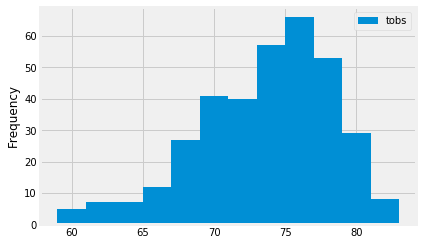

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps=session.query(Measurement.tobs).filter(Measurement.date>=year_ago).filter(Measurement.station==mostactivestationstr).all()
temps_df = pd.DataFrame(temps, columns =['tobs'])
temps_df.head(10)
temps_df.plot.hist(bins=12)
plt.show()

![precipitation](Images/station-histogram.png)

In [17]:
#this isn't part of the readme so I skipped
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
year_agostr=str(year_ago)
print(calc_temps(year_agostr,laststr))
#print(calc_temps('2016-08-23', '2017-08-23'))
tripavgtemp = calc_temps(year_agostr,laststr)

[(58.0, 74.59058295964125, 87.0)]


In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tripavgtemp_df = pd.DataFrame(tripavgtemp, columns =['tmin', 'Trip Avg Temp', 'tmax'])
#y_axis = tripavgtemp_df['Trip Avg Temp']
#print(y_axis)
tripavgtemp_df.head(10)
#tripavgtemp_df.plot.bar(y=tripavgtemp_df['Trip Avg Temp'])
#plt.show()

,tmin,Trip Avg Temp,tmax
0,58.0,74.590583,87.0
